In [355]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18, 6)
mpl.rcParams['axes.grid'] = False

In [356]:
#locally weighted regression
def lwr(inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)    
    for i in range(m):
        ypred[i] = inp[i] * beta(inp[i], inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred

def lwr1(x0, inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)    
    ypred = x0 * beta(x0, inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred

def beta(point, inp, out, k):
    wt = kernal(point, inp, k)
    #print("The weight of betas is",wt)
    beta_val = (inp.T * (wt*inp)).I * (inp.T * wt * out)
    #print("The weight is beta value is",beta_val)
    return beta_val

def kernal(point, inp, k):
    l,b = np.shape(inp)
    weights = np.mat(np.eye((l)))
    #print(weights)    
    for i in range(l):
        diff = point - inp[i]
        weights[i,i] = np.exp(np.dot(diff,diff.T) / (-2.0 * (k**2)))
    return weights

In [357]:
#dataset preparation with lag
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [358]:
data = pd.read_csv('/home/kishora/Documents/Datasets/allYearHarangi.csv', header=0, index_col=0)
dataset=data.drop(columns = ['Present Storage(TMC)', 'Reservoir Level(TMC)', 'Outflow'])
values = dataset.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 4, 1)#lag of 4 days
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
4,0.001823,0.0,0.0,0.0,0.003068,0.0,0.0,0.0,0.002131,0.0,0.0,0.0,0.001515,0.0,0.0,0.0,0.001669
5,0.003068,0.0,0.0,0.0,0.002131,0.0,0.0,0.0,0.001515,0.0,0.0,0.0,0.001669,0.0,0.0,0.0,0.002144
6,0.002131,0.0,0.0,0.0,0.001515,0.0,0.0,0.0,0.001669,0.0,0.0,0.0,0.002144,0.0,0.0,0.0,0.001913
7,0.001515,0.0,0.0,0.0,0.001669,0.0,0.0,0.0,0.002144,0.0,0.0,0.0,0.001913,0.0,0.0,0.0,0.001682
8,0.001669,0.0,0.0,0.0,0.002144,0.0,0.0,0.0,0.001913,0.0,0.0,0.0,0.001682,0.0,0.0,0.0,0.001438


In [364]:
#train test split
values = reframed.values
n_hours = 4
n_features = 4
n_train_days = (365 * 2)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
train_y = train_y.reshape((train_y.shape[0],1))
# test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(730, 16) 730 (730,)


In [ ]:
import timeit
start = timeit.default_timer()
ypred=[]
# get normalized inflow for each test input 
for i in test_X:
    ypred.append(lwr1(i, train_X, train_y, 7))
ypred = np.array(ypred).reshape(test_y.shape[0],1)
stop = timeit.default_timer()
print('Time: ', stop - start)  

In [361]:
test_y=test_y.reshape(test_y.shape[0],1)

In [362]:
# inverse the normalized values to actual
inv_yhat = np.concatenate((ypred, test_X[:, -3:]), axis=1)
out=scaler.inverse_transform(inv_yhat) 
out=out[:,0]
tar_y = np.concatenate((test_y, test_X[:, -3:]), axis=1)
tar=scaler.inverse_transform(tar_y)
tar=tar[:,0]

In [363]:
print("MSE = ",metrics.mean_squared_error(tar,out))
print("RMSE = ",sqrt(metrics.mean_squared_error(tar,out)))

MSE =  3805610.895572704
RMSE =  1950.7975024519342


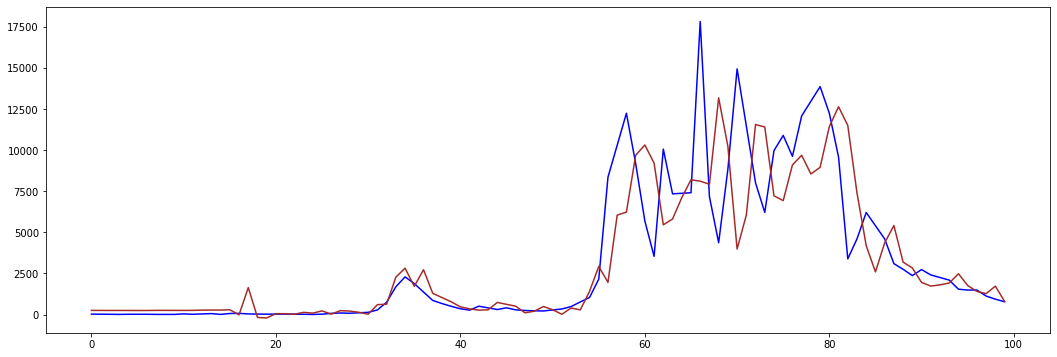

In [354]:
pt.plot(tar[500:600],c='blue')
pt.plot(out[500:600],c='brown')

In [ ]:
# for e in range(epoch):
#     rand = np.zeros((2919,4))
#     for i in range(3):
#         rand+= i[:,i].dot(w[i])
#     out = rand.reshape(2919,4,1)+bias